In [1]:
# 1. Importações (todas no início)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random


# 2. Configuração do dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# 3. Carregamento dos dados e DataLoaders
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

loaders = {
    'train' : DataLoader(train_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1),

    'test'  : DataLoader(test_data,
                         batch_size=100,
                         shuffle=True,
                         num_workers=1)
}


# 4. Definição da classe CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1 , 10 , kernel_size=5)
        self.conv2 = nn.Conv2d(10 , 20 ,kernel_size=5)
        self.Conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320 , 50)
        self.fc2 = nn.Linear(50,10)

    def forward(self , x):
        x = F.relu(F.max_pool2d(self.conv1(x) , 2))
        x = F.relu(F.max_pool2d(self.Conv2_drop(self.conv2(x)) , 2))
        x = x.view(-1 ,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x , training=self.training)
        x = self.fc2(x)
        # MUITO IMPORTANTE: Remova F.softmax(x) daqui se estiver usando nn.CrossEntropyLoss()
        return x # Retorna os logits brutos


# 5. Instância do modelo, otimizador e função de perda
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()


# 6. Funções de Treinamento e Teste
def train(epoch):
    model.train()
    for batch_idx, (data , target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output , target) # loss_fn espera logits se for CrossEntropyLoss
        loss.backward()
        optimizer.step()
        if batch_idx % 20 ==0:
          print(f"Train Epoch: {epoch} [{batch_idx * len (data)}/ {len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data , target = data.to(device) , target.to(device)
            output = model(data)
            test_loss += loss_fn(output , target).item() # loss_fn espera logits
            # Para a predição, aplicamos softmax aqui se ele foi removido do forward
            pred = output.argmax(dim = 1 , keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f"\nTest set : Average loss: {test_loss:.4f} , Accuracy {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%\n)")


In [2]:
for epoch in range(1,11):
  train(epoch)
  test()

Train Epoch: 1 [0/ 60000 (0%)]	2.304708
Train Epoch: 1 [2000/ 60000 (3%)]	2.191044
Train Epoch: 1 [4000/ 60000 (7%)]	1.607700
Train Epoch: 1 [6000/ 60000 (10%)]	1.224256
Train Epoch: 1 [8000/ 60000 (13%)]	0.992272
Train Epoch: 1 [10000/ 60000 (17%)]	0.784837
Train Epoch: 1 [12000/ 60000 (20%)]	0.857315
Train Epoch: 1 [14000/ 60000 (23%)]	0.693071
Train Epoch: 1 [16000/ 60000 (27%)]	0.620256
Train Epoch: 1 [18000/ 60000 (30%)]	0.600873
Train Epoch: 1 [20000/ 60000 (33%)]	0.434223
Train Epoch: 1 [22000/ 60000 (37%)]	0.609470
Train Epoch: 1 [24000/ 60000 (40%)]	0.666265
Train Epoch: 1 [26000/ 60000 (43%)]	0.482844
Train Epoch: 1 [28000/ 60000 (47%)]	0.417885
Train Epoch: 1 [30000/ 60000 (50%)]	0.534334
Train Epoch: 1 [32000/ 60000 (53%)]	0.539167
Train Epoch: 1 [34000/ 60000 (57%)]	0.494853
Train Epoch: 1 [36000/ 60000 (60%)]	0.458238
Train Epoch: 1 [38000/ 60000 (63%)]	0.470699
Train Epoch: 1 [40000/ 60000 (67%)]	0.432395
Train Epoch: 1 [42000/ 60000 (70%)]	0.355751
Train Epoch: 1 [44000

In [3]:
torch.save(model.state_dict(), "modelo_mnist.pth")



--- Modo de Previsão de Imagem ---

Você digitou: 4
O modelo preveu: 4
Rótulo verdadeiro da imagem: 4


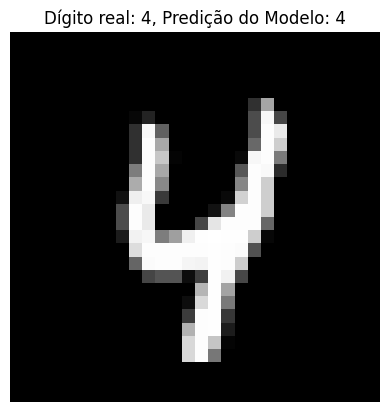

Por favor, digite um número entre 0 e 9.

Você digitou: 8
O modelo preveu: 8
Rótulo verdadeiro da imagem: 8


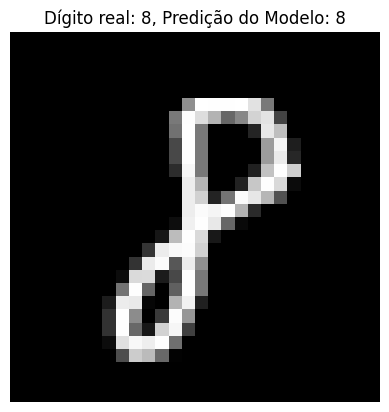

Encerrando o programa.
Programa finalizado.


In [4]:

model.eval()

print("\n--- Modo de Previsão de Imagem ---")
while True:
    user_input = input("Digite um número de 0 a 9 para ver uma imagem e a previsão (ou 'sair' para encerrar): ")

    if user_input.lower() == 'sair':
        print("Encerrando o programa.")
        break

    try:
        digit = int(user_input)
        if not (0 <= digit <= 9):
            print("Por favor, digite um número entre 0 e 9.")
            continue
    except ValueError:
        print("Entrada inválida. Por favor, digite um número ou 'sair'.")
        continue

    # Encontrar todas as imagens que correspondem ao dígito desejado
    matching_indices = [i for i, (img, label) in enumerate(test_data) if label ==digit]

    if not matching_indices:
        print(f"Não foram encontradas imagens para o dígito {digit} no conjunto de teste.")
        continue

    # Selecionar uma imagem aleatória
    selected_index = random.choice(matching_indices)
    data, target = test_data[selected_index]

    # Preparar a imagem para o modelo
    data_for_model = data.unsqueeze(0).to(device)

    # Fazer a previsão
    with torch.no_grad():
        output = model(data_for_model)
        
        probabilities = F.softmax(output, dim=1)
        prediction = probabilities.argmax(dim=1, keepdim=True).item()
        
    # Exibir o resultado
    print(f'\nVocê digitou: {digit}')
    print(f'O modelo preveu: {prediction}')
    print(f'Rótulo verdadeiro da imagem: {target}')

    # Preparar a imagem para visualização
    image_to_show = data.squeeze(0).cpu().numpy()

    plt.imshow(image_to_show, cmap='gray')
    plt.title(f"Dígito real: {target}, Predição do Modelo: {prediction}")
    plt.axis('off')
    plt.show()

print("Programa finalizado.")